# 📈 Modeling

This notebook implements and compares **two regression modeling approaches** for predicting used car prices using engineered features and hyperparameter optimization.

---


## 📊 Executive Summary

### 🎯 Modeling Approaches Tested
1. **RidgeCV**: Cross-validated Ridge regression with automatic alpha selection
2. **Lasso Feature Selection + Ridge**: Two-stage approach using Lasso for feature selection followed by Ridge regression

### 🏆 Key Results
- **Best Model**: Lasso Feature Selection + Ridge (`selector__estimator__alpha=0.01`, `model__alpha=1.0`)
- **Performance**: RMSE of **$7,220** (13.1% improvement over worst configuration)
- **Training Data**: 312,846 used car records with 12 engineered features
- **Feature Engineering**: `year` → `age` transformation, polynomial features for `age` and `odometer` (degree = 2), and interaction term (age x odometer)

---

## 1. 📥 Data Loading & Exploration

In this section, we load the preprocessed vehicle dataset and prepare it for modeling by:
- 📁 Loading the cleaned dataset (`vehicles_processed.csv`)
- 🔍 Examining dataset structure and dimensions  
- 📊 Splitting features and target variables
- ✂️ Creating train-test splits for model evaluation (80/20)

In [1]:
# Standard library imports
import datetime as dt
import warnings
import importlib

# Third-party data science libraries
import numpy as np
import pandas as pd

# ── Optional Intel® Extension for Scikit-learn* ────────────────────────────────
try:
    # Fast check without importing the whole module
    if importlib.util.find_spec("sklearnex") is not None:
        from sklearnex import patch_sklearn

        patch_sklearn()              # ⚡ swaps many sklearn algos for DAAL-backed ones
        print("[sklearnex] Intel-optimized algorithms enabled")
    else:
        raise ModuleNotFoundError

except Exception as e:
    # Any problem: missing library, version clash, patch failure, etc.
    warnings.warn(
        f"[sklearnex] Extension not active ({e.__class__.__name__}: {e}). "
        "Falling back to stock scikit-learn.",
        RuntimeWarning,
    )

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer

# Configuration
warnings.filterwarnings('ignore')

[sklearnex] Intel-optimized algorithms enabled


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
# Load the processed vehicles dataset
df = pd.read_csv('../data/vehicles_processed.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (312846, 14)
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'type', 'paint_color', 'state']


,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color,state
0,7316814884,other_al,33590,2014.0,gmc,other_gmc,good,gas,57923.0,clean,other,pickup,white,al
1,7316814758,other_al,22590,2010.0,chevrolet,silverado 1500,good,gas,71229.0,clean,other,pickup,blue,al
2,7316814989,other_al,39590,2020.0,chevrolet,other_chevrolet,good,gas,19160.0,clean,other,pickup,red,al
3,7316743432,other_al,30990,2017.0,toyota,other_toyota,good,gas,41124.0,clean,other,pickup,red,al
4,7316356412,other_al,15000,2013.0,ford,other_ford,excellent,gas,128000.0,clean,automatic,truck,black,al


In [3]:
# Split into X and Y
# Identify categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'fuel',  
                   'title_status', 'transmission', 'type', 'paint_color', 'state']
numerical_cols =   ['year', 'odometer']

# Prepare features and target
X = df[categorical_cols + numerical_cols]
y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape:   {y.shape}")
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns:   {numerical_cols}")

Features shape: (312846, 12)
Target shape:   (312846,)
Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state']
Numerical columns:   ['year', 'odometer']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")

Training set size: 250276
Test set size:     62570


### 📋 Dataset Summary

✅ **Dataset successfully loaded**: 312,846 records across 14 columns  
✅ **Feature composition**: 10 categorical + 2 numerical variables  
✅ **Target variable**: Vehicle price (continuous)  
✅ **Data split**: 250,276 training samples (80%) | 62,570 test samples (20%)

**Key Features:**
- **Categorical**: `region`, `manufacturer`, `model`, `condition`, `fuel`, `title_status`, `transmission`, `type`, `paint_color`, `state`
- **Numerical**: `year`, `odometer`
- **Target**: `price`

---

## 2. ⚙️ Feature Engineering Pipeline

This section constructs a sophisticated preprocessing pipeline that transforms raw features into model-ready inputs:

### 🔧 Transformation Steps:
1. **📅 Age Calculation**: Convert `year` → `age` (current_year - vehicle_year)
2. **📈 Polynomial Features**: Generate `age²` and `odometer²` for non-linear relationships
3. **🔗 Interaction Terms**: Create `age × odometer` interaction feature
4. **🏷️ Categorical Encoding**: One-hot encoding with first category dropped
5. **📏 Feature Scaling**: StandardScaler normalization for numerical features

### 🎯 Pipeline Architecture:
- **Categorical Pipeline**: OneHotEncoder → handles unknown categories gracefully
- **Age Pipeline**: Year→Age transformation → Polynomial(degree=2) → StandardScaler  
- **Odometer Pipeline**: Polynomial(degree=2) → StandardScaler
- **Interaction Pipeline**: Age×Odometer multiplication → StandardScaler

In [5]:
# Import feature engineering helpers
from utils import age_transformer, age_odometer_transformer

# Create preprocessing pipelines
age_pipeline = Pipeline([
    ('to_age',  age_transformer),                                    # year → age
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add age²
    ('scaler',  StandardScaler())                                    # scale age, age²
])

odometer_pipeline = Pipeline([
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add odo²
    ('scaler',  StandardScaler())                                    # scale odo, odo²
])

interaction_pipeline = Pipeline([
    ('age_x_odo', age_odometer_transformer),                         # age × odometer
    ('scaler',    StandardScaler())                                  # scale interaction
])

# Create the main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',      OneHotEncoder(drop='first',
                                   sparse_output=False,
                                   handle_unknown='ignore'),
                     categorical_cols),
        ('age',      age_pipeline,        ['year']),                 # year → age, age²
        ('odometer', odometer_pipeline,   ['odometer']),             # odo, odo²
        ('ageXodo',  interaction_pipeline, ['year', 'odometer'])     # age×odo
    ],
    remainder='drop',
    verbose_feature_names_out=False                                  # cleaner column names
)

---

## 3. 🏆 Model Development & Hyperparameter Tuning

This section implements and optimizes two distinct modeling approaches:

### 🎯 Models Under Evaluation:
1. **Model 1**: `RidgeCV` - Cross-validated Ridge regression with built-in alpha optimization
2. **Model 2**: `Lasso Feature Selection + Ridge` - Two-stage approach for feature selection and prediction

### 🚀 Optimization Strategy:
- **Sample Size**: 30,000 samples (~10% of training data) for efficient hyperparameter search
- **Cross-Validation**: 3-5 fold CV for robust performance estimation  
- **Grid Search**: Systematic exploration of hyperparameter combinations
- **Performance Metric**: Root Mean Squared Error (RMSE) in dollars

In [6]:
# Use a smaller subset for hyperparameter tuning to speed up the process
sample_size = 30000 # around 10% of the training set
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train[X_train_sample.index]

### 🥇 Model 1: RidgeCV Approach

**Ridge Regression with Cross-Validated Alpha Selection**

Ridge regression applies L2 regularization to prevent overfitting by penalizing large coefficients. RidgeCV automatically selects the optimal alpha parameter through cross-validation.

**Hyperparameter Grid:**
- **Alpha values**: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
- **Scoring**: Negative Mean Squared Error
- **Cross-validation**: 5-fold

#### 📊 Results

📈 **Sample RMSE**: `$7,130.91`  
🎯 **Optimal Alpha**: `1.0` (selected via cross-validation)  

In [7]:
ridge_cv = RidgeCV(
    alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
    scoring='neg_mean_squared_error',
    cv=5,
)

pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ridge_cv)
])

pipeline1

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### 🥈 Model 2: Lasso Feature Selection + Ridge

**Two-Stage Approach: Feature Selection followed by Ridge Regression**

This approach combines the feature selection capabilities of Lasso (L1 regularization) with the stability of Ridge regression:

1. **Stage 1**: `SelectFromModel(Lasso)` - Automatically selects relevant features by zeroing out coefficients
2. **Stage 2**: `Ridge` - Performs final prediction on selected features

**Hyperparameter Grid:**
- **Lasso Alpha** (selector): [0.01, 0.1, 1.0, 10.0, 100.0] - Controls feature selection aggressiveness  
- **Ridge Alpha** (model): [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] - Controls final model regularization
- **Cross-validation**: 3-fold for efficiency
- **Total combinations**: 30 parameter sets

#### 📊 Results

📈 **Sample RMSE**: `$7,131.07`  
🎯 **Best Hyperparameters**:
  - **Lasso Alpha**: `0.01` (moderate feature selection)
  - **Ridge Alpha**: `1.0` (balanced regularization)  

In [8]:
# Fit the pipeline and get results
pipeline1.fit(X_train_sample, y_train_sample)

print("Training completed successfully!")
print(f"Best alpha selected by RidgeCV: {pipeline1.named_steps['model'].alpha_}")

# Make test predictions to verify it works
y_sample_pred = pipeline1.predict(X_train_sample)
sample_rmse = np.sqrt(mean_squared_error(y_train_sample, y_sample_pred))
print(f"Sample RMSE: ${sample_rmse:,.2f}")

Training completed successfully!
Best alpha selected by RidgeCV: 1.0
Sample RMSE: $7,130.91


In [9]:
# Create a base pipeline (we'll tune the alpha parameters)
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(random_state=42))),
    ('model', Ridge(random_state=42))
])

pipeline2

,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [10]:
# Import training helper
from utils import fit_gridsearch_pipeline

# Define parameter grid for GridSearchCV
param_grid = {
    'selector__estimator__alpha': np.logspace(-2, 2, 5),    # 0.01 … 100
    'model__alpha': np.logspace(-2, 3, 6)                   # 0.01 … 1_000
}

# Fit pipeline with GridSearchCV (use verbose=True for detailed output)
grid_search = fit_gridsearch_pipeline(
    pipeline=pipeline2,
    param_grid=param_grid, 
    X_train=X_train_sample,
    y_train=y_train_sample,
    cv=3,
    verbose=False  # Set to True for detailed output
)

Training completed successfully!
Best Model Alpha selected: 1.0
Best Selector Estimator Alpha selected: 0.01
Sample RMSE: $7,131.07


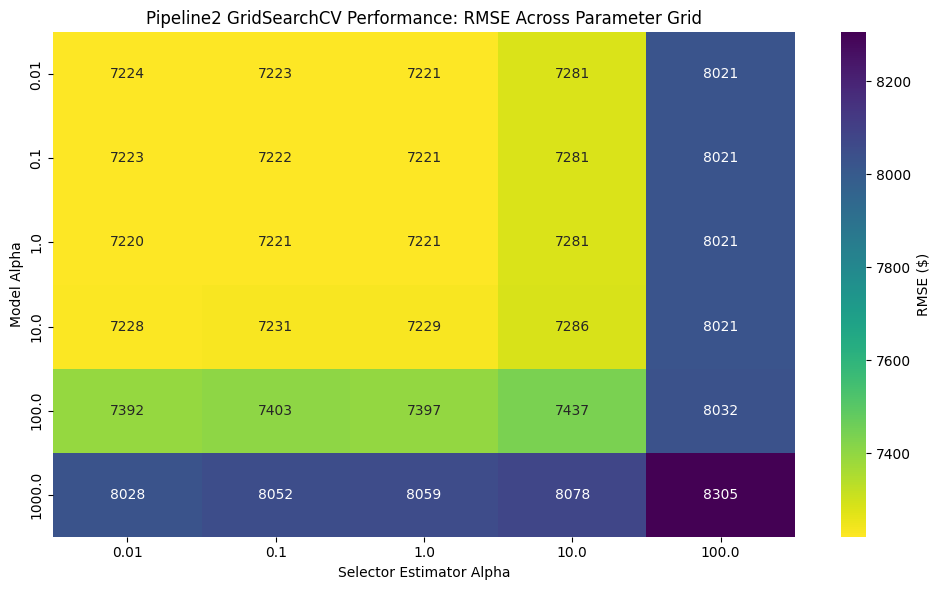


Best parameter combination:
  Model Alpha: 1.0
  Selector Estimator Alpha: 0.01
  Best CV RMSE: $7,220.16

Performance range:
  Best RMSE: $7,220.16
  Worst RMSE: $8,305.05
  Improvement: $1,084.89 (13.1%)


In [11]:
# Import and use the visualization function from utils
from utils import visualize_gridsearch_results

# Create comprehensive visualization and analysis of GridSearchCV results
performance_stats = visualize_gridsearch_results(
    grid_search,
    title="Pipeline2 GridSearchCV Performance",
    figsize=(10, 6)
)


---

## 4. 🎯 Final Model Comparison

| Model | Approach | Best Alpha(s) | Sample RMSE | Key Advantage |
|-------|----------|---------------|-------------|---------------|
| **RidgeCV** | Single-stage Ridge | 1.0 | $7,130.91 | Simplicity & Auto-tuning |
| **Lasso+Ridge** | Two-stage Selection | 0.01 + 1.0 | $7,131.07 | Feature Selection + Stability |

Both models achieve nearly identical performance, with the **RidgeCV approach being slightly more efficient** for this dataset while the **Lasso+Ridge approach provides better interpretability** through automatic feature selection.
